# U-Net Model for RV Segmentation

## Training U-Net CNN

In [1]:
import sys
sys.path.append("..")
import os, re, glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from src import data,unet

Using TensorFlow backend.


In [2]:
from keras import utils

train_dir = "/home/ubuntu/trainingdata/TrainingSet"
#train_dir = "/Users/aksharkumar/Documents/mlndCapstone/trainingdata/TrainingSet"

images=[]
inner_masks=[]
outer_masks = []

patient_directories = sorted(glob.glob(os.path.join(train_dir, "patient*")))

for patient_dir in patient_directories:
    imgdata = data.ImageData(patient_dir)
    images += imgdata.labeled_images
    inner_masks += imgdata.endo_masks
    outer_masks += imgdata.epi_masks

images = np.asarray(images)[:,:,:,None].astype('float64')
i_masks = np.asarray(inner_masks)
o_masks = np.asarray(outer_masks)

dims = i_masks.shape
classes = len(set(i_masks[0].flatten()))
new_shape = dims + (classes,)
i_masks = utils.to_categorical(i_masks).reshape(new_shape)
o_masks = utils.to_categorical(o_masks).reshape(new_shape)

def normalize(x, epsilon=1e-7, axis=(1,2)):
    x -= np.mean(x, axis=axis, keepdims=True)
    x /= np.std(x, axis=axis, keepdims=True) + epsilon
    
normalize(images,axis=(1,2))

print("There are %d total training images." % len(images))
print("There are %d total inner masks." % len(inner_masks))
print("There are %d total outer masks." % len(outer_masks))


There are 243 total training images.
There are 243 total inner masks.
There are 243 total outer masks.


In [15]:
height,width,_ = images[0].shape
dropout = 0.0

unet_conv = unet.UNet()

model = unet_conv.get_unet(height=height,width=width,channels=1,features=64,steps=3,dropout=dropout,padding='same')

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 216, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_35 (Conv2D)               (None, 216, 256, 64)  640         input_3[0][0]                    
____________________________________________________________________________________________________
activation_33 (Activation)       (None, 216, 256, 64)  0           conv2d_35[0][0]                  
____________________________________________________________________________________________________
dropout_33 (Dropout)             (None, 216, 256, 64)  0           activation_33[0][0]              
___________________________________________________________________________________________

In [17]:
from keras.optimizers import Adam
from keras import backend as K

def dice_coef(y_true, y_pred):
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    intersection = K.sum(flat_y_true * flat_y_pred)
    return (2. * intersection + 1.) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + 1.)

def dice_coef_np(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (np.sum(y_true) + np.sum(y_pred) + 1.)


def pixelwise_crossentropy(y_true, y_pred, weights=[0.5,0.5], epsilon=1e-8):
    ndim = K.ndim(y_pred)
    ncategory = K.int_shape(y_pred)[-1]
    # scale predictions so class probabilities of each pixel sum to 1
    y_pred /= K.sum(y_pred, axis=(ndim-1), keepdims=True)
    y_pred = K.clip(y_pred, epsilon, 1-epsilon)
    w = K.constant(weights) * (ncategory / sum(weights))
    # first, average over all axis except classes
    cross_entropies = -K.mean(y_true * K.log(y_pred), axis=tuple(range(ndim-1)))
    return K.sum(w * cross_entropies)


def show_plots(history):    
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice')
    plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
#sgd = optimizers.SGD(lr=0.01, momentum=0.99)
model.compile(optimizer=Adam(lr=1e-5),loss=[pixelwise_crossentropy],metrics=[dice_coef])

In [5]:
#TODO: 1. split data into training and validation set
#      2. Augment the data
#      3. Train model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from math import ceil

seed = 62

validation_split=0.2

epochs = 500
batch_size = 32


split_index = int((1 - validation_split) * len(images))

train_steps = ceil(split_index / batch_size)
val_steps = ceil((len(images)-split_index )/batch_size)

train_images = images[:split_index]
train_inner_masks = i_masks[:split_index]

validation_images = images[split_index:]
validation_inner_masks = i_masks[split_index:]


data_gen_args = dict(featurewise_std_normalization=True,
                     rotation_range=180,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.01,
                     fill_mode='nearest')

train_images_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**data_gen_args)


#seed = 1
#height,width,channels = train_images[0].shape
#print(train_images[0].shape)
#print(train_inner_masks[0].shape)
train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_inner_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_inner_masks, y=None, seed=seed)


train_generator = zip(train_images_generator, train_masks_generator)




/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).


In [18]:
checkpointer = ModelCheckpoint(filepath='saved_models/endo_models/weights500No64.hdf5', verbose=1, save_best_only=True)

hist = model.fit_generator(train_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=1,callbacks=[checkpointer],
                   validation_data=(validation_images,validation_inner_masks),validation_steps=val_steps)
#show_plots(hist)

Epoch 1/500
7/7 [==============================] - 49s - loss: 0.6682 - dice_coef: 0.4913 - val_loss: 0.6921 - val_dice_coef: 0.5006
Epoch 2/500
7/7 [==============================] - 30s - loss: 0.6669 - dice_coef: 0.4920 - val_loss: 0.6901 - val_dice_coef: 0.5016
Epoch 3/500
7/7 [==============================] - 30s - loss: 0.6644 - dice_coef: 0.4934 - val_loss: 0.6853 - val_dice_coef: 0.5039
Epoch 4/500
7/7 [==============================] - 30s - loss: 0.6578 - dice_coef: 0.4968 - val_loss: 0.6741 - val_dice_coef: 0.5097
Epoch 5/500
7/7 [==============================] - 30s - loss: 0.6416 - dice_coef: 0.5054 - val_loss: 0.6445 - val_dice_coef: 0.5255
Epoch 6/500
7/7 [==============================] - 30s - loss: 0.5980 - dice_coef: 0.5301 - val_loss: 0.5706 - val_dice_coef: 0.5693
Epoch 7/500
7/7 [==============================] - 30s - loss: 0.5013 - dice_coef: 0.5954 - val_loss: 0.4286 - val_dice_coef: 0.6782
Epoch 8/500
7/7 [==============================] - 30s - loss: 0.3744

7/7 [==============================] - 30s - loss: 0.1688 - dice_coef: 0.8842 - val_loss: 0.1541 - val_dice_coef: 0.9053
Epoch 26/500
7/7 [==============================] - 30s - loss: 0.1597 - dice_coef: 0.8867 - val_loss: 0.1518 - val_dice_coef: 0.9103
Epoch 27/500
7/7 [==============================] - 30s - loss: 0.1623 - dice_coef: 0.8911 - val_loss: 0.1515 - val_dice_coef: 0.9077
Epoch 28/500
7/7 [==============================] - 30s - loss: 0.1576 - dice_coef: 0.8886 - val_loss: 0.1497 - val_dice_coef: 0.9107
Epoch 29/500
7/7 [==============================] - 30s - loss: 0.1507 - dice_coef: 0.8947 - val_loss: 0.1484 - val_dice_coef: 0.9126
Epoch 30/500
7/7 [==============================] - 30s - loss: 0.1500 - dice_coef: 0.8946 - val_loss: 0.1466 - val_dice_coef: 0.9160
Epoch 31/500
7/7 [==============================] - 30s - loss: 0.1558 - dice_coef: 0.8920 - val_loss: 0.1468 - val_dice_coef: 0.9089
Epoch 32/500
7/7 [==============================] - 30s - loss: 0.1504 - di

7/7 [==============================] - 30s - loss: 0.1116 - dice_coef: 0.9161 - val_loss: 0.1290 - val_dice_coef: 0.9352
Epoch 53/500
7/7 [==============================] - 30s - loss: 0.1125 - dice_coef: 0.9119 - val_loss: 0.1347 - val_dice_coef: 0.9405
Epoch 54/500
7/7 [==============================] - 30s - loss: 0.1122 - dice_coef: 0.9141 - val_loss: 0.1250 - val_dice_coef: 0.9298
Epoch 55/500
7/7 [==============================] - 30s - loss: 0.1090 - dice_coef: 0.9164 - val_loss: 0.1262 - val_dice_coef: 0.9351
Epoch 56/500
7/7 [==============================] - 30s - loss: 0.1234 - dice_coef: 0.9014 - val_loss: 0.1252 - val_dice_coef: 0.9335
Epoch 57/500
7/7 [==============================] - 30s - loss: 0.1092 - dice_coef: 0.9170 - val_loss: 0.1262 - val_dice_coef: 0.9350
Epoch 58/500
7/7 [==============================] - 30s - loss: 0.1176 - dice_coef: 0.9086 - val_loss: 0.1296 - val_dice_coef: 0.9394
Epoch 59/500
7/7 [==============================] - 30s - loss: 0.1132 - di

7/7 [==============================] - 30s - loss: 0.1088 - dice_coef: 0.9126 - val_loss: 0.1171 - val_dice_coef: 0.9345
Epoch 82/500
7/7 [==============================] - 30s - loss: 0.1062 - dice_coef: 0.9150 - val_loss: 0.1174 - val_dice_coef: 0.9346
Epoch 83/500
7/7 [==============================] - 30s - loss: 0.1083 - dice_coef: 0.9143 - val_loss: 0.1186 - val_dice_coef: 0.9368
Epoch 84/500
7/7 [==============================] - 30s - loss: 0.1030 - dice_coef: 0.9178 - val_loss: 0.1207 - val_dice_coef: 0.9410
Epoch 85/500
7/7 [==============================] - 30s - loss: 0.1045 - dice_coef: 0.9174 - val_loss: 0.1166 - val_dice_coef: 0.9369
Epoch 86/500
7/7 [==============================] - 30s - loss: 0.1141 - dice_coef: 0.9107 - val_loss: 0.1156 - val_dice_coef: 0.9348
Epoch 87/500
7/7 [==============================] - 30s - loss: 0.0999 - dice_coef: 0.9197 - val_loss: 0.1194 - val_dice_coef: 0.9423
Epoch 88/500
7/7 [==============================] - 30s - loss: 0.1108 - di

7/7 [==============================] - 30s - loss: 0.1086 - dice_coef: 0.9103 - val_loss: 0.1089 - val_dice_coef: 0.9408
Epoch 112/500
7/7 [==============================] - 30s - loss: 0.1019 - dice_coef: 0.9198 - val_loss: 0.1069 - val_dice_coef: 0.9377
Epoch 113/500
7/7 [==============================] - 30s - loss: 0.1073 - dice_coef: 0.9147 - val_loss: 0.1063 - val_dice_coef: 0.9378
Epoch 114/500
7/7 [==============================] - 30s - loss: 0.1002 - dice_coef: 0.9190 - val_loss: 0.1070 - val_dice_coef: 0.9414
Epoch 115/500
7/7 [==============================] - 30s - loss: 0.1106 - dice_coef: 0.9089 - val_loss: 0.1064 - val_dice_coef: 0.9406
Epoch 116/500
7/7 [==============================] - 30s - loss: 0.1094 - dice_coef: 0.9163 - val_loss: 0.1078 - val_dice_coef: 0.9379
Epoch 117/500
7/7 [==============================] - 30s - loss: 0.0962 - dice_coef: 0.9225 - val_loss: 0.1081 - val_dice_coef: 0.9414
Epoch 118/500
7/7 [==============================] - 30s - loss: 0.10

7/7 [==============================] - 30s - loss: 0.0984 - dice_coef: 0.9186 - val_loss: 0.1062 - val_dice_coef: 0.9482
Epoch 141/500
7/7 [==============================] - 30s - loss: 0.1086 - dice_coef: 0.9131 - val_loss: 0.1030 - val_dice_coef: 0.9401
Epoch 142/500
7/7 [==============================] - 30s - loss: 0.0987 - dice_coef: 0.9213 - val_loss: 0.1038 - val_dice_coef: 0.9430
Epoch 143/500
7/7 [==============================] - 30s - loss: 0.0909 - dice_coef: 0.9222 - val_loss: 0.1072 - val_dice_coef: 0.9486
Epoch 144/500
7/7 [==============================] - 30s - loss: 0.0994 - dice_coef: 0.9187 - val_loss: 0.1041 - val_dice_coef: 0.9421
Epoch 145/500
7/7 [==============================] - 30s - loss: 0.0978 - dice_coef: 0.9245 - val_loss: 0.1036 - val_dice_coef: 0.9411
Epoch 146/500
7/7 [==============================] - 30s - loss: 0.1010 - dice_coef: 0.9164 - val_loss: 0.1009 - val_dice_coef: 0.9420
Epoch 147/500
7/7 [==============================] - 30s - loss: 0.09

7/7 [==============================] - 30s - loss: 0.0877 - dice_coef: 0.9276 - val_loss: 0.1007 - val_dice_coef: 0.9426
Epoch 172/500
7/7 [==============================] - 30s - loss: 0.0926 - dice_coef: 0.9222 - val_loss: 0.1028 - val_dice_coef: 0.9493
Epoch 173/500
7/7 [==============================] - 30s - loss: 0.0908 - dice_coef: 0.9243 - val_loss: 0.1012 - val_dice_coef: 0.9468
Epoch 174/500
7/7 [==============================] - 30s - loss: 0.1001 - dice_coef: 0.9212 - val_loss: 0.0966 - val_dice_coef: 0.9410
Epoch 175/500
7/7 [==============================] - 30s - loss: 0.0951 - dice_coef: 0.9216 - val_loss: 0.0963 - val_dice_coef: 0.9415
Epoch 176/500
7/7 [==============================] - 30s - loss: 0.0884 - dice_coef: 0.9247 - val_loss: 0.0988 - val_dice_coef: 0.9441
Epoch 177/500
7/7 [==============================] - 30s - loss: 0.0902 - dice_coef: 0.9234 - val_loss: 0.0963 - val_dice_coef: 0.9436
Epoch 178/500
7/7 [==============================] - 30s - loss: 0.09

7/7 [==============================] - 30s - loss: 0.0917 - dice_coef: 0.9276 - val_loss: 0.1001 - val_dice_coef: 0.9384
Epoch 202/500
7/7 [==============================] - 30s - loss: 0.0886 - dice_coef: 0.9274 - val_loss: 0.0987 - val_dice_coef: 0.9429
Epoch 203/500
7/7 [==============================] - 30s - loss: 0.0950 - dice_coef: 0.9223 - val_loss: 0.1009 - val_dice_coef: 0.9497
Epoch 204/500
7/7 [==============================] - 30s - loss: 0.0904 - dice_coef: 0.9253 - val_loss: 0.1029 - val_dice_coef: 0.9492
Epoch 205/500
7/7 [==============================] - 30s - loss: 0.0860 - dice_coef: 0.9265 - val_loss: 0.0965 - val_dice_coef: 0.9474
Epoch 206/500
7/7 [==============================] - 30s - loss: 0.0898 - dice_coef: 0.9254 - val_loss: 0.0938 - val_dice_coef: 0.9477
Epoch 207/500
7/7 [==============================] - 30s - loss: 0.0840 - dice_coef: 0.9289 - val_loss: 0.0987 - val_dice_coef: 0.9486
Epoch 208/500
7/7 [==============================] - 30s - loss: 0.08

7/7 [==============================] - 30s - loss: 0.0914 - dice_coef: 0.9258 - val_loss: 0.0968 - val_dice_coef: 0.9522
Epoch 233/500
7/7 [==============================] - 30s - loss: 0.0894 - dice_coef: 0.9276 - val_loss: 0.0939 - val_dice_coef: 0.9442
Epoch 234/500
7/7 [==============================] - 30s - loss: 0.0881 - dice_coef: 0.9256 - val_loss: 0.0946 - val_dice_coef: 0.9436
Epoch 235/500
7/7 [==============================] - 30s - loss: 0.0867 - dice_coef: 0.9279 - val_loss: 0.0939 - val_dice_coef: 0.9454
Epoch 236/500
7/7 [==============================] - 30s - loss: 0.0787 - dice_coef: 0.9314 - val_loss: 0.0949 - val_dice_coef: 0.9507
Epoch 237/500
7/7 [==============================] - 30s - loss: 0.0900 - dice_coef: 0.9251 - val_loss: 0.0978 - val_dice_coef: 0.9496
Epoch 238/500
7/7 [==============================] - 30s - loss: 0.0852 - dice_coef: 0.9312 - val_loss: 0.0979 - val_dice_coef: 0.9509
Epoch 239/500
7/7 [==============================] - 30s - loss: 0.08

7/7 [==============================] - 30s - loss: 0.0812 - dice_coef: 0.9315 - val_loss: 0.0942 - val_dice_coef: 0.9548
Epoch 265/500
7/7 [==============================] - 30s - loss: 0.0821 - dice_coef: 0.9323 - val_loss: 0.0906 - val_dice_coef: 0.9507
Epoch 266/500
7/7 [==============================] - 30s - loss: 0.0806 - dice_coef: 0.9323 - val_loss: 0.0867 - val_dice_coef: 0.9504
Epoch 267/500
7/7 [==============================] - 30s - loss: 0.0852 - dice_coef: 0.9288 - val_loss: 0.0883 - val_dice_coef: 0.9498
Epoch 268/500
7/7 [==============================] - 30s - loss: 0.0808 - dice_coef: 0.9308 - val_loss: 0.0894 - val_dice_coef: 0.9513
Epoch 269/500
7/7 [==============================] - 30s - loss: 0.0758 - dice_coef: 0.9367 - val_loss: 0.0872 - val_dice_coef: 0.9506
Epoch 270/500
7/7 [==============================] - 30s - loss: 0.0771 - dice_coef: 0.9328 - val_loss: 0.0837 - val_dice_coef: 0.9535
Epoch 271/500
7/7 [==============================] - 30s - loss: 0.07

7/7 [==============================] - 30s - loss: 0.0794 - dice_coef: 0.9332 - val_loss: 0.0903 - val_dice_coef: 0.9524
Epoch 296/500
7/7 [==============================] - 30s - loss: 0.0722 - dice_coef: 0.9352 - val_loss: 0.0879 - val_dice_coef: 0.9529
Epoch 297/500
7/7 [==============================] - 30s - loss: 0.0707 - dice_coef: 0.9380 - val_loss: 0.0883 - val_dice_coef: 0.9534
Epoch 298/500
7/7 [==============================] - 30s - loss: 0.0682 - dice_coef: 0.9419 - val_loss: 0.0920 - val_dice_coef: 0.9473
Epoch 299/500
7/7 [==============================] - 30s - loss: 0.0797 - dice_coef: 0.9314 - val_loss: 0.0981 - val_dice_coef: 0.9551
Epoch 300/500
7/7 [==============================] - 30s - loss: 0.0738 - dice_coef: 0.9370 - val_loss: 0.0952 - val_dice_coef: 0.9547
Epoch 301/500
7/7 [==============================] - 30s - loss: 0.0673 - dice_coef: 0.9407 - val_loss: 0.0928 - val_dice_coef: 0.9550
Epoch 302/500
7/7 [==============================] - 30s - loss: 0.07

7/7 [==============================] - 30s - loss: 0.0678 - dice_coef: 0.9400 - val_loss: 0.0889 - val_dice_coef: 0.9517
Epoch 328/500
7/7 [==============================] - 30s - loss: 0.0710 - dice_coef: 0.9374 - val_loss: 0.0866 - val_dice_coef: 0.9571
Epoch 329/500
7/7 [==============================] - 30s - loss: 0.0686 - dice_coef: 0.9413 - val_loss: 0.0857 - val_dice_coef: 0.9561
Epoch 330/500
7/7 [==============================] - 30s - loss: 0.0649 - dice_coef: 0.9409 - val_loss: 0.0861 - val_dice_coef: 0.9532
Epoch 331/500
7/7 [==============================] - 30s - loss: 0.0669 - dice_coef: 0.9390 - val_loss: 0.0938 - val_dice_coef: 0.9543
Epoch 332/500
7/7 [==============================] - 30s - loss: 0.0699 - dice_coef: 0.9394 - val_loss: 0.0929 - val_dice_coef: 0.9538
Epoch 333/500
7/7 [==============================] - 30s - loss: 0.0679 - dice_coef: 0.9408 - val_loss: 0.0937 - val_dice_coef: 0.9559
Epoch 334/500
7/7 [==============================] - 30s - loss: 0.07

7/7 [==============================] - 30s - loss: 0.0705 - dice_coef: 0.9389 - val_loss: 0.0789 - val_dice_coef: 0.9568
Epoch 360/500
7/7 [==============================] - 30s - loss: 0.0655 - dice_coef: 0.9408 - val_loss: 0.0812 - val_dice_coef: 0.9570
Epoch 361/500
7/7 [==============================] - 30s - loss: 0.0624 - dice_coef: 0.9434 - val_loss: 0.0831 - val_dice_coef: 0.9583
Epoch 362/500
7/7 [==============================] - 30s - loss: 0.0608 - dice_coef: 0.9462 - val_loss: 0.0811 - val_dice_coef: 0.9578
Epoch 363/500
7/7 [==============================] - 30s - loss: 0.0638 - dice_coef: 0.9431 - val_loss: 0.0806 - val_dice_coef: 0.9572
Epoch 364/500
7/7 [==============================] - 30s - loss: 0.0673 - dice_coef: 0.9430 - val_loss: 0.0856 - val_dice_coef: 0.9545
Epoch 365/500
7/7 [==============================] - 30s - loss: 0.0851 - dice_coef: 0.9361 - val_loss: 0.0877 - val_dice_coef: 0.9576
Epoch 366/500
7/7 [==============================] - 30s - loss: 0.06

7/7 [==============================] - 30s - loss: 0.0605 - dice_coef: 0.9445 - val_loss: 0.0758 - val_dice_coef: 0.9613
Epoch 392/500
7/7 [==============================] - 30s - loss: 0.0589 - dice_coef: 0.9451 - val_loss: 0.0762 - val_dice_coef: 0.9609
Epoch 393/500
7/7 [==============================] - 30s - loss: 0.0540 - dice_coef: 0.9481 - val_loss: 0.0776 - val_dice_coef: 0.9610
Epoch 394/500
7/7 [==============================] - 30s - loss: 0.0595 - dice_coef: 0.9455 - val_loss: 0.0794 - val_dice_coef: 0.9616
Epoch 395/500
7/7 [==============================] - 30s - loss: 0.0651 - dice_coef: 0.9455 - val_loss: 0.0871 - val_dice_coef: 0.9591
Epoch 396/500
7/7 [==============================] - 30s - loss: 0.0717 - dice_coef: 0.9400 - val_loss: 0.0927 - val_dice_coef: 0.9610
Epoch 397/500
7/7 [==============================] - 30s - loss: 0.0637 - dice_coef: 0.9464 - val_loss: 0.0809 - val_dice_coef: 0.9568
Epoch 398/500
7/7 [==============================] - 30s - loss: 0.06

7/7 [==============================] - 30s - loss: 0.0552 - dice_coef: 0.9456 - val_loss: 0.0789 - val_dice_coef: 0.9609
Epoch 423/500
7/7 [==============================] - 30s - loss: 0.0579 - dice_coef: 0.9464 - val_loss: 0.0756 - val_dice_coef: 0.9632
Epoch 424/500
7/7 [==============================] - 30s - loss: 0.0589 - dice_coef: 0.9479 - val_loss: 0.0787 - val_dice_coef: 0.9595
Epoch 425/500
7/7 [==============================] - 30s - loss: 0.0556 - dice_coef: 0.9476 - val_loss: 0.0778 - val_dice_coef: 0.9615
Epoch 426/500
7/7 [==============================] - 30s - loss: 0.0527 - dice_coef: 0.9499 - val_loss: 0.0776 - val_dice_coef: 0.9610
Epoch 427/500
7/7 [==============================] - 30s - loss: 0.0540 - dice_coef: 0.9483 - val_loss: 0.0783 - val_dice_coef: 0.9608
Epoch 428/500
7/7 [==============================] - 30s - loss: 0.0489 - dice_coef: 0.9532 - val_loss: 0.0790 - val_dice_coef: 0.9589
Epoch 429/500
7/7 [==============================] - 30s - loss: 0.05

7/7 [==============================] - 30s - loss: 0.0516 - dice_coef: 0.9509 - val_loss: 0.0784 - val_dice_coef: 0.9653
Epoch 455/500
7/7 [==============================] - 30s - loss: 0.0623 - dice_coef: 0.9487 - val_loss: 0.0839 - val_dice_coef: 0.9575
Epoch 456/500
7/7 [==============================] - 30s - loss: 0.0747 - dice_coef: 0.9441 - val_loss: 0.1123 - val_dice_coef: 0.9609
Epoch 457/500
7/7 [==============================] - 30s - loss: 0.0652 - dice_coef: 0.9431 - val_loss: 0.1057 - val_dice_coef: 0.9627
Epoch 458/500
7/7 [==============================] - 30s - loss: 0.0662 - dice_coef: 0.9440 - val_loss: 0.0852 - val_dice_coef: 0.9543
Epoch 459/500
7/7 [==============================] - 30s - loss: 0.0600 - dice_coef: 0.9473 - val_loss: 0.0838 - val_dice_coef: 0.9520
Epoch 460/500
7/7 [==============================] - 30s - loss: 0.0561 - dice_coef: 0.9427 - val_loss: 0.0772 - val_dice_coef: 0.9597
Epoch 461/500
7/7 [==============================] - 30s - loss: 0.05

7/7 [==============================] - 30s - loss: 0.0489 - dice_coef: 0.9514 - val_loss: 0.0735 - val_dice_coef: 0.9628
Epoch 487/500
7/7 [==============================] - 30s - loss: 0.0488 - dice_coef: 0.9520 - val_loss: 0.0730 - val_dice_coef: 0.9627
Epoch 488/500
7/7 [==============================] - 30s - loss: 0.0496 - dice_coef: 0.9519 - val_loss: 0.0789 - val_dice_coef: 0.9627
Epoch 489/500
7/7 [==============================] - 30s - loss: 0.0500 - dice_coef: 0.9534 - val_loss: 0.0778 - val_dice_coef: 0.9623
Epoch 490/500
7/7 [==============================] - 30s - loss: 0.0497 - dice_coef: 0.9524 - val_loss: 0.0697 - val_dice_coef: 0.9670
Epoch 491/500
7/7 [==============================] - 30s - loss: 0.0503 - dice_coef: 0.9527 - val_loss: 0.0731 - val_dice_coef: 0.9638
Epoch 492/500
7/7 [==============================] - 30s - loss: 0.0490 - dice_coef: 0.9518 - val_loss: 0.0717 - val_dice_coef: 0.9648
Epoch 493/500
7/7 [==============================] - 30s - loss: 0.04

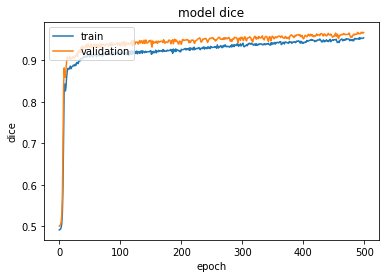

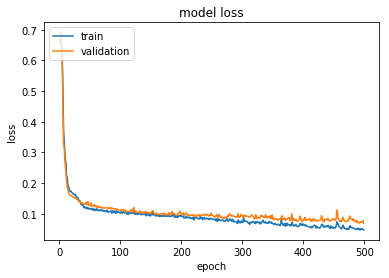

In [19]:
#print(np.max(hist.history['val_dice_coef']))
#print(np.max(hist.history['dice_coef']))

# model.load_weights('saved_models/weights.hdf5')
show_plots(hist)


250 Epochs, 0.5 Dropout


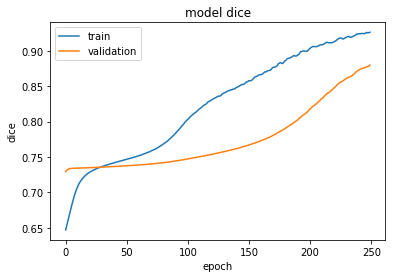

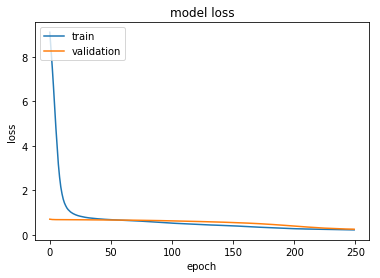

In [27]:
print("250 Epochs, 0.5 Dropout")
show_plots(hist)

300 Epochs, no dropout


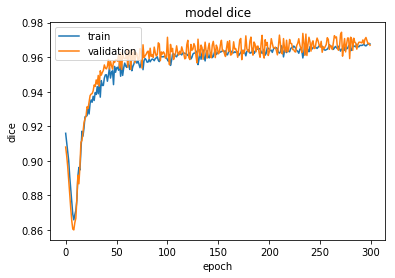

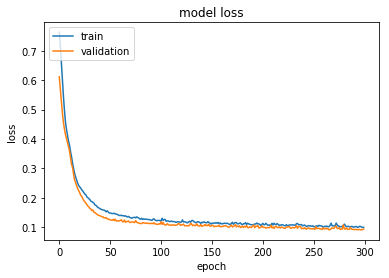

In [9]:
print("300 Epochs, no dropout")
show_plots(hist)

250 Epochs, no dropout


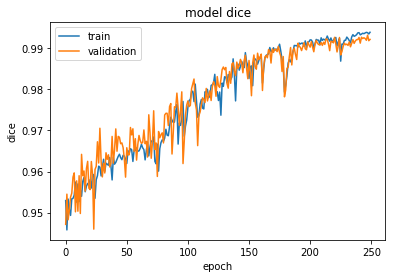

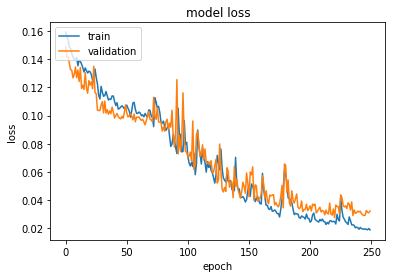

In [12]:
print("250 Epochs, no dropout")
show_plots(hist)

In [11]:
import tensorflow as tf

model.load_weights('saved_models/endo_models/weightsNoDrop.hdf5')
def calculate_dice(images, masks_true):
    dices = []
   # image = images[0]
    #mask_pred = model.predict(image[None,:,:,:])
    #print(mask_pred.shape)
    #mask_true = masks_true[0]
    #dims = mask_true.shape
    #mask_pred_re = utils.to_categorical(mask_pred).reshape(dims)
    #print(mask_true.shape)
    #print(mask_pred_re.shape)
    #y_true = mask_true.astype('float64')
    #y_pred = mask_pred[0,:,:,:].astype('float64')
    
    #print(y_true.shape)
    #print(y_true.flatten().shape)
    #print(y_pred.shape)
    #print(y_pred.flatten().shape)
    #print(K.flatten(y_true))
    #print(K.flatten(y_pred))
    #dice = dice_coef(y_true.flatten(),y_pred.flatten())
    #for image,mask_true in zip(images,masks_true):
     #   mask_pred = model.predict(image[None,:,:,:])
      #  y_true = mask_true[:,:,1].astype('float64')
       # y_pred = mask_pred[:,:,1].astype('float64')
        #dices.append(dice_coef(y_true,y_pred))
    
    masks_pred = np.concatenate([model.predict(image[None,:,:,:]) for image in images])
    for mask_true, mask_pred in zip(masks_true, masks_pred):
        y_true = mask_true.astype('float64')
        y_pred = mask_pred.astype('float64')
        dices.append(dice_coef_np(y_true.flatten(), y_pred.flatten()))
    #print(dices)
    #dice_tf = K.constant(dices,dtype='float64')
    #print(masks_pred)
    print("Dice Average: {:.2f} Dice Stdev: {:.2f}".format(np.mean(dices), np.std(dices)))
    #print(dice)
print("Training Statistics(No Dropout)...")
calculate_dice(train_images,train_inner_masks)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images,validation_inner_masks)


Training Statistics(No Dropout)...
Dice Average: 0.95 Dice Stdev: 0.04
Validation Statistics(No Dropout)...
Dice Average: 0.96 Dice Stdev: 0.03


# Results of Endocardium Model

## Training
hyperparams: {Dropout:0.5, Epochs:50, Batch Size: 20}

- train_dice = 0.62365097794
- val_dice = 0.522672422078

hyperparams: {Dropout:0.5, Epochs: 200, Batch Size: 20}

- train_dice = 0.878794970879
- val_dice = 0.841971736781

hyperparams: {Dropout:0.0, Epochs:200, Batch Size: 20}
- train_dice = 0.91 +/- 0.03
- val_dice = 0.92 +/- 0.02


In [6]:
model_epi = unet_conv.get_unet(height=height,width=width,channels=1,features=32,steps=3,dropout=dropout,padding='same')

model_epi.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 216, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 216, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 216, 256, 32) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 216, 256, 32) 0           activation_15[0][0]              
__________________________________________________________________________________________________
conv2d_17 

In [7]:
seed_epi = 10

train_outer_masks = o_masks[:split_index]

train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_outer_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_outer_masks, y=None, seed=seed)


train_outer_generator = zip(train_images_generator, train_masks_generator)

validation_outer_masks = o_masks[split_index:]
model_epi.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=[dice_coef])

/Users/aksharkumar/miniconda2/envs/rvenv/lib/python3.6/site-packages/keras/preprocessing/image.py:722: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
/Users/aksharkumar/miniconda2/envs/rvenv/lib/python3.6/site-packages/keras/preprocessing/image.py:896: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [11]:

checkpointer = ModelCheckpoint(filepath='saved_models/epi_models/weightsNoDrop.hdf5',verbose=1,save_best_only=True)

hist_epi = model_epi.fit_generator(train_outer_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=2,callbacks=[checkpointer],
                                 validation_data=(validation_images,validation_outer_masks),validation_steps=val_steps)

Epoch 1/200
Epoch 00000: val_loss improved from inf to 0.69272, saving model to saved_models/epi_models/weightsNoDrop.hdf5
17s - loss: 0.7114 - dice_coef: 0.4918 - val_loss: 0.6927 - val_dice_coef: 0.5005
Epoch 2/200
Epoch 00001: val_loss improved from 0.69272 to 0.67302, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.6831 - dice_coef: 0.5055 - val_loss: 0.6730 - val_dice_coef: 0.5106
Epoch 3/200
Epoch 00002: val_loss improved from 0.67302 to 0.63828, saving model to saved_models/epi_models/weightsNoDrop.hdf5
14s - loss: 0.6564 - dice_coef: 0.5199 - val_loss: 0.6383 - val_dice_coef: 0.5298
Epoch 4/200
Epoch 00003: val_loss improved from 0.63828 to 0.56203, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.6017 - dice_coef: 0.5529 - val_loss: 0.5620 - val_dice_coef: 0.5782
Epoch 5/200
Epoch 00004: val_loss improved from 0.56203 to 0.44360, saving model to saved_models/epi_models/weightsNoDrop.hdf5
14s - loss: 0.4909 - dice_coef: 0.6352 - 

Epoch 00041: val_loss improved from 0.21776 to 0.21727, saving model to saved_models/epi_models/weightsNoDrop.hdf5
14s - loss: 0.2240 - dice_coef: 0.8644 - val_loss: 0.2173 - val_dice_coef: 0.8753
Epoch 43/200
Epoch 00042: val_loss did not improve
15s - loss: 0.2223 - dice_coef: 0.8653 - val_loss: 0.2179 - val_dice_coef: 0.8787
Epoch 44/200
Epoch 00043: val_loss improved from 0.21727 to 0.21656, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.2155 - dice_coef: 0.8734 - val_loss: 0.2166 - val_dice_coef: 0.8738
Epoch 45/200
Epoch 00044: val_loss did not improve
14s - loss: 0.2279 - dice_coef: 0.8646 - val_loss: 0.2176 - val_dice_coef: 0.8647
Epoch 46/200
Epoch 00045: val_loss did not improve
15s - loss: 0.2122 - dice_coef: 0.8738 - val_loss: 0.2176 - val_dice_coef: 0.8703
Epoch 47/200
Epoch 00046: val_loss did not improve
14s - loss: 0.2273 - dice_coef: 0.8650 - val_loss: 0.2167 - val_dice_coef: 0.8684
Epoch 48/200
Epoch 00047: val_loss improved from 0.21656 to 0

Epoch 00093: val_loss did not improve
14s - loss: 0.1746 - dice_coef: 0.8956 - val_loss: 0.1924 - val_dice_coef: 0.8854
Epoch 95/200
Epoch 00094: val_loss did not improve
15s - loss: 0.1857 - dice_coef: 0.8942 - val_loss: 0.1921 - val_dice_coef: 0.8841
Epoch 96/200
Epoch 00095: val_loss did not improve
14s - loss: 0.1833 - dice_coef: 0.8889 - val_loss: 0.1910 - val_dice_coef: 0.8827
Epoch 97/200
Epoch 00096: val_loss improved from 0.18983 to 0.18977, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.1837 - dice_coef: 0.8899 - val_loss: 0.1898 - val_dice_coef: 0.8849
Epoch 98/200
Epoch 00097: val_loss did not improve
14s - loss: 0.1748 - dice_coef: 0.8965 - val_loss: 0.1932 - val_dice_coef: 0.8744
Epoch 99/200
Epoch 00098: val_loss did not improve
15s - loss: 0.1802 - dice_coef: 0.8953 - val_loss: 0.1899 - val_dice_coef: 0.8885
Epoch 100/200
Epoch 00099: val_loss improved from 0.18977 to 0.18926, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - los

Epoch 00147: val_loss did not improve
15s - loss: 0.1876 - dice_coef: 0.8849 - val_loss: 0.1887 - val_dice_coef: 0.8745
Epoch 149/200
Epoch 00148: val_loss did not improve
15s - loss: 0.1808 - dice_coef: 0.8922 - val_loss: 0.1897 - val_dice_coef: 0.8748
Epoch 150/200
Epoch 00149: val_loss did not improve
14s - loss: 0.1869 - dice_coef: 0.8861 - val_loss: 0.1866 - val_dice_coef: 0.9015
Epoch 151/200
Epoch 00150: val_loss did not improve
15s - loss: 0.1749 - dice_coef: 0.8925 - val_loss: 0.1848 - val_dice_coef: 0.8984
Epoch 152/200
Epoch 00151: val_loss did not improve
14s - loss: 0.1950 - dice_coef: 0.8738 - val_loss: 0.1835 - val_dice_coef: 0.8878
Epoch 153/200
Epoch 00152: val_loss did not improve
15s - loss: 0.1864 - dice_coef: 0.8921 - val_loss: 0.1917 - val_dice_coef: 0.8696
Epoch 154/200
Epoch 00153: val_loss did not improve
14s - loss: 0.1773 - dice_coef: 0.8915 - val_loss: 0.1819 - val_dice_coef: 0.8911
Epoch 155/200
Epoch 00154: val_loss did not improve
15s - loss: 0.1770 - dic

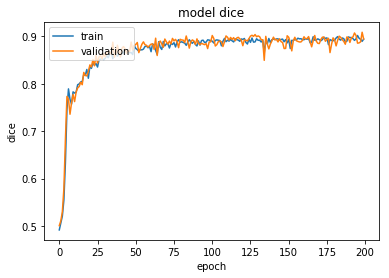

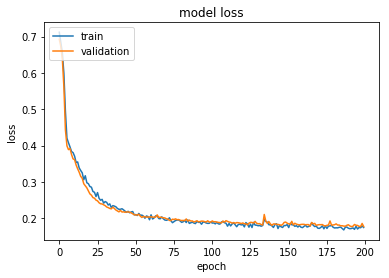

In [12]:
show_plots(hist_epi)

In [53]:
model_epi.load_weights('saved_models/epi_models/weightsNoDrop.hdf5')

print("Epicardium Model Results")
print("========================")
print("Training Statistics(No Dropout)...")
calculate_dice(train_images,train_outer_masks)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images,validation_outer_masks)

Epicardium Model Results
Training Statistics(No Dropout)...
Dice Average: 0.90 Dice Stdev: 0.03
Validation Statistics(No Dropout)...
Dice Average: 0.91 Dice Stdev: 0.03


In [20]:
model.load_weights('saved_models/endo_models/weights-500Epoch-50Drop.hdf5')
print("Training Statistics(500 Epochs, 0.5 Dropout)...")
calculate_dice(train_images,train_inner_masks)
print("Validation Statistics(500 Epochs, 0.5 Dropout)...")
calculate_dice(validation_images,validation_inner_masks)


Training Statistics(500 Epochs, 0.5 Dropout)...
Dice Average: 0.91 Dice Stdev: 0.03
Validation Statistics(500 Epochs, 0.5 Dropout)...
Dice Average: 0.93 Dice Stdev: 0.03


In [13]:
model.load_weights('saved_models/endo_models/weights-300Epochs-NoDrop.hdf5')
print("Training Statistics(300 Epochs, No Dropout)...")
calculate_dice(train_images,train_inner_masks)
print("Validation Statistics(300 Epochs, No Dropout)...")
calculate_dice(validation_images,validation_inner_masks)

Training Statistics(300 Epochs, No Dropout)...
Dice Average: 0.94 Dice Stdev: 0.03
Validation Statistics(300 Epochs, No Dropout)...
Dice Average: 0.94 Dice Stdev: 0.03


In [12]:
model.load_weights('saved_models/endo_models/weights-500Epochs-NoDrop.hdf5')
print("Training Statistics(500 Epochs, No Dropout)...")
calculate_dice(train_images,train_inner_masks)
print("Validation Statistics(500 Epochs, No Dropout)...")
calculate_dice(validation_images,validation_inner_masks)

Training Statistics(500 Epochs, No Dropout)...
Dice Average: 0.95 Dice Stdev: 0.02
Validation Statistics(500 Epochs, No Dropout)...
Dice Average: 0.95 Dice Stdev: 0.02


# View Predictions on training

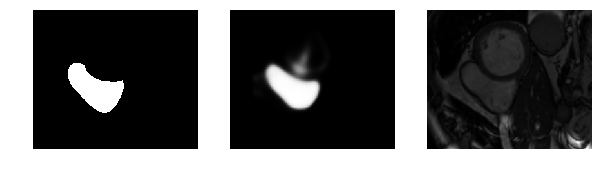

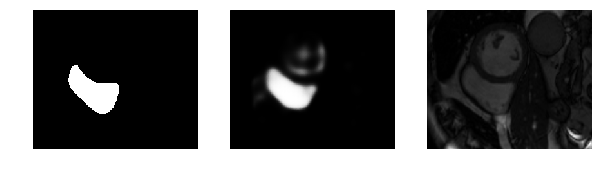

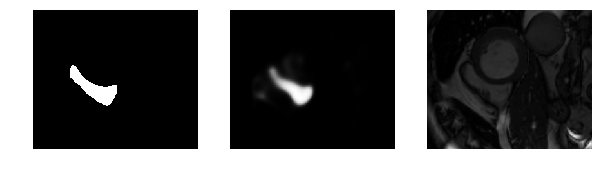

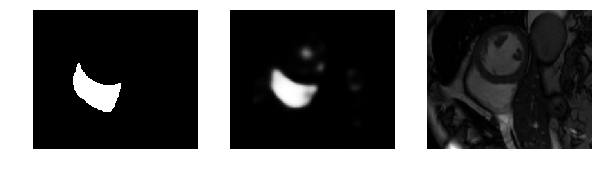

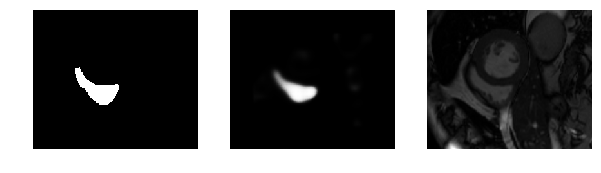

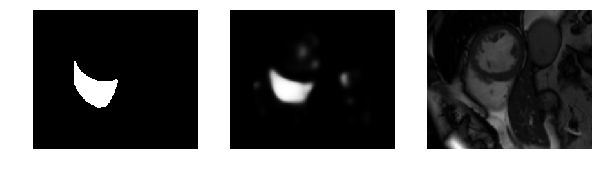

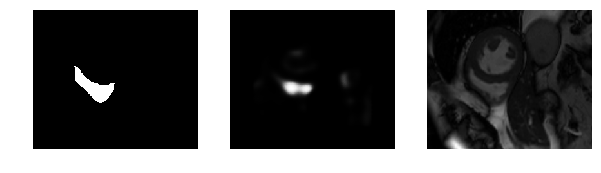

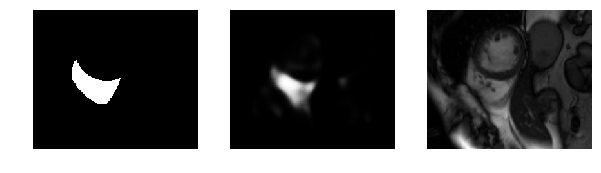

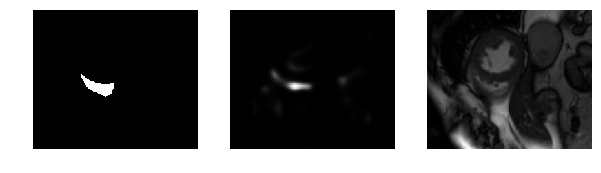

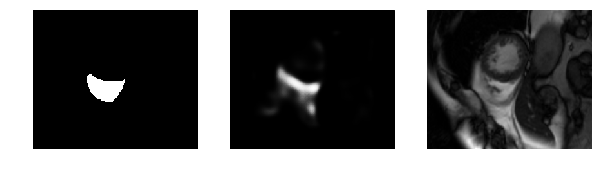

In [20]:
model.load_weights('saved_models/endo_models/weights500No64.hdf5')

def show_masks(images, i_masks_true):
    masks_pred = np.concatenate([model.predict(image[None,:,:,:]) for image in images])
    for (image,i_mask,mask_pred) in zip(images,i_masks_true,masks_pred):
        plt.figure(figsize=(10,5))
        plt.subplot(1, 3, 1)
        plt.axis("off")
        #print(mask.shape)
        #print(image.shape)
        plt.imshow(i_mask, cmap=plt.cm.gray)
        plt.subplot(1,3,2)
        plt.axis("off")
        plt.imshow(mask_pred[:,:,1],cmap=plt.cm.gray)
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.imshow(image[:,:,0], cmap=plt.cm.gray)
        
show_masks(images[:10], inner_masks[:10])